In [1]:
import os
os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import math
import numpy as np
import pandas as pd
import datetime
import pytz
from datetime import datetime, timedelta
from watttime import WattTimeForecast, WattTimeHistorical

import optimizer.s3 as s3u
import evaluation.eval_framework as efu

import watttime.shared_anniez.alg.optCharger as optC
import watttime.shared_anniez.alg.moer as Moer

region = "LDWP" # Los Angeles
username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

actual_data = WattTimeHistorical(username, password)
hist_data = WattTimeForecast(username, password)

s3 = s3u.s3_utils()
key = '20240715_1k_synth_users.csv'
generated_data = s3.load_csvdataframe(file=key)

# Synthetic User Data

In [2]:
synth_data = generated_data.copy(deep=True)

synth_data["plug_in_time"] = pd.to_datetime(synth_data["plug_in_time"])
synth_data["unplug_time"] = pd.to_datetime(synth_data["unplug_time"])

In [5]:
# one user - 10 sessions - Feb 2024
synth_data = synth_data.query('user_type == "r4.736000000000001_tc95_avglc23868_sdlc7685"').sample(10)

## API Data

In [6]:
synth_data['moer_data'] = synth_data.apply(
    lambda x: efu.get_historical_fcst_data(
    x.plug_in_time,
    math.ceil(x.total_intervals_plugged_in),
    region = region
    ), axis = 1
)

synth_data['moer_data_actual'] = synth_data.apply(
    lambda x: efu.get_historical_actual_data(
    x.plug_in_time,
    math.ceil(x.total_intervals_plugged_in),
    region = region
    ), axis = 1
)

## MOER - No Optimization

In [14]:
synth_data['charger_greedy']= synth_data.apply(
    lambda x: efu.get_schedule_and_cost(
        x.MWh_fraction,
        x.charged_kWh_actual / 1000,
        math.ceil(x.total_intervals_plugged_in), # will throw an error if the plug in time is too shart to reach full charge, should soften to a warning
        x.moer_data,
        asap = True
        ), 
        axis = 1
        )

synth_data['charger_greedy_actual']= synth_data.apply(
    lambda x: efu.get_schedule_and_cost(
        x.MWh_fraction,
        x.charged_kWh_actual / 1000,
        math.ceil(x.total_intervals_plugged_in), # will throw an error if the plug in time is too shart to reach full charge, should soften to a warning
        x.moer_data_actual,
        asap = True
        ), 
        axis = 1
        )

Greedy fit!
[0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.0003946666666666, 0.00039

In [15]:
synth_data['greedy_fit_results'] = synth_data['charger_greedy'].apply(
    lambda  x: x.get_total_cost()
    )

synth_data['greedy_fit_results_actual'] = synth_data['charger_greedy_actual'].apply(
    lambda  x: x.get_total_cost()
    )

In [16]:
abs(synth_data['greedy_fit_results_actual'] - synth_data['greedy_fit_results']).mean()

0.6017087999998981

In [18]:
synth_data['greedy_fit_results_actual'].sum()

408.4957866665977

In [19]:
synth_data['greedy_fit_results'].sum()

404.88600746659824

## MOER - Simple Optimization

In [9]:
synth_data['charger_simple']= synth_data.apply(
    lambda x: efu.get_schedule_and_cost(
        x.MWh_fraction,
        x.charged_kWh_actual / 1000,
        math.ceil(x.total_intervals_plugged_in), # will throw an error if the plug in time is too shart to reach full charge, should soften to a warning
        x.moer_data,
        asap = False
        ), 
        axis = 1
        )

synth_data['charger_simple_actual']= synth_data.apply(
    lambda x: efu.get_schedule_and_cost(
        x.MWh_fraction,
        x.charged_kWh_actual / 1000,
        math.ceil(x.total_intervals_plugged_in), # will throw an error if the plug in time is too shart to reach full charge, should soften to a warning
        x.moer_data_actual,
        asap = False
        ), 
        axis = 1
        )

Simple fit!
Simple fit!
Simple fit!
Simple fit!
Simple fit!
Simple fit!
Simple fit!
Simple fit!
Simple fit!
Simple fit!
Simple fit!
Simple fit!
Simple fit!
Simple fit!
Simple fit!
Simple fit!
Simple fit!
Simple fit!
Simple fit!
Simple fit!


In [10]:
synth_data['simple_fit_results'] = synth_data['charger_simple'].apply(
    lambda  x: x.get_total_cost()
    )

synth_data['simple_fit_results_actual'] = synth_data['charger_simple_actual'].apply(
    lambda  x: x.get_total_cost()
    )

In [11]:
abs(synth_data['simple_fit_results_actual'] - synth_data['simple_fit_results']).mean()

0.6452326399998913

In [12]:
synth_data['simple_fit_results_actual'].sum()

408.34458986659774

In [17]:
synth_data['simple_fit_results'].sum()

404.2995722665984

## Results

In [20]:
synth_data.head()

,index,distinct_dates,user_type,plug_in_time,unplug_time,initial_charge,total_seconds_to_95,full_charge_time,length_plugged_in,charged_kWh_actual,...,moer_data,moer_data_actual,charger_simple,charger_simple_actual,simple_fit_results,simple_fit_results_actual,charger_greedy,charger_greedy_actual,greedy_fit_results,greedy_fit_results_actual
0,0,2024-02-01,r4.736000000000001_tc95_avglc23868_sdlc7685,2024-02-01 18:57:09,2024-02-02 03:32:39.208738,0.401701,39594.218740,2024-02-02 05:57:03.218739729,30930.208738,40.690408,...,point_time value ...,point_time value 0 2024...,<watttime.shared_anniez.alg.optCharger.OptChar...,<watttime.shared_anniez.alg.optCharger.OptChar...,47.187491,46.927485,<watttime.shared_anniez.alg.optCharger.OptChar...,<watttime.shared_anniez.alg.optCharger.OptChar...,47.187491,46.927485
11,11,2024-02-12,r4.736000000000001_tc95_avglc23868_sdlc7685,2024-02-12 20:55:17,2024-02-13 05:13:22.682396,0.386995,40656.153181,2024-02-13 08:12:53.153181158,29885.682396,39.316276,...,point_time value ...,point_time value 0 2024...,<watttime.shared_anniez.alg.optCharger.OptChar...,<watttime.shared_anniez.alg.optCharger.OptChar...,45.048832,46.714049,<watttime.shared_anniez.alg.optCharger.OptChar...,<watttime.shared_anniez.alg.optCharger.OptChar...,45.048832,46.714049
3,3,2024-02-04,r4.736000000000001_tc95_avglc23868_sdlc7685,2024-02-04 20:01:01,2024-02-05 03:02:13.433692,0.511739,31648.068617,2024-02-05 04:48:29.068617082,25272.433692,33.247291,...,point_time value ...,point_time value 0 2024-0...,<watttime.shared_anniez.alg.optCharger.OptChar...,<watttime.shared_anniez.alg.optCharger.OptChar...,38.696790,38.323081,<watttime.shared_anniez.alg.optCharger.OptChar...,<watttime.shared_anniez.alg.optCharger.OptChar...,38.696790,38.323081
6,6,2024-02-07,r4.736000000000001_tc95_avglc23868_sdlc7685,2024-02-07 19:30:02,2024-02-08 01:25:49.657105,0.441537,36717.533436,2024-02-08 05:41:59.533436413,21347.657105,28.084029,...,point_time value ...,point_time value 0 2024-0...,<watttime.shared_anniez.alg.optCharger.OptChar...,<watttime.shared_anniez.alg.optCharger.OptChar...,32.945116,32.720353,<watttime.shared_anniez.alg.optCharger.OptChar...,<watttime.shared_anniez.alg.optCharger.OptChar...,32.945116,32.720353
1,1,2024-02-02,r4.736000000000001_tc95_avglc23868_sdlc7685,2024-02-02 18:09:48,2024-02-02 22:16:56.655053,0.522494,30871.411993,2024-02-03 02:44:19.411992549,14828.655053,19.507920,...,point_time value ...,point_time value 0 2024-0...,<watttime.shared_anniez.alg.optCharger.OptChar...,<watttime.shared_anniez.alg.optCharger.OptChar...,22.589339,22.315006,<watttime.shared_anniez.alg.optCharger.OptChar...,<watttime.shared_anniez.alg.optCharger.OptChar...,22.589339,22.315006


In [25]:
synth_data = synth_data.set_index('distinct_dates').sort_index()

In [36]:
print( (synth_data["greedy_fit_results_actual"] - synth_data["simple_fit_results"]).sum(),"lbs of marginal emissions")

4.196214399999317 lbs of marginal emissions


In [42]:
synth_data[["greedy_fit_results_actual","simple_fit_results"]]

,greedy_fit_results_actual,simple_fit_results
distinct_dates,,
2024-02-01,46.927485,47.187491
2024-02-02,22.315006,22.589339
2024-02-03,36.751202,36.602137
2024-02-04,38.323081,38.696790
2024-02-06,39.314167,38.783459
2024-02-07,32.720353,32.945116
2024-02-09,44.155978,44.226820
2024-02-11,32.900992,32.683452
2024-02-12,46.714049,45.048832


<Axes: title={'center': 'Simple Optimization vs Baseline Actuals'}, xlabel='distinct_dates'>

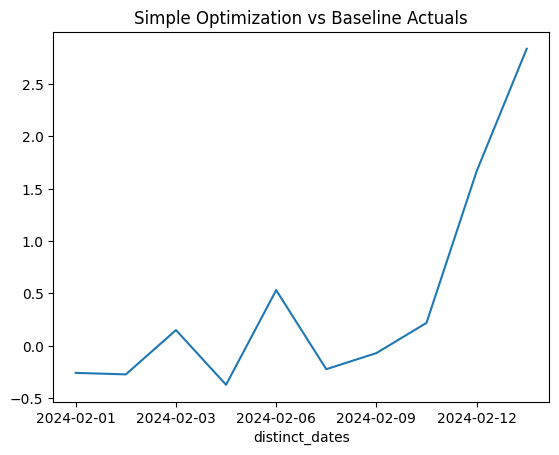

In [29]:

(synth_data["greedy_fit_results_actual"] - synth_data["simple_fit_results"]).plot(kind='line', title = "Simple Optimization vs Baseline Actuals")

<Axes: title={'center': 'Simple Optimization vs Baseline Forecast'}, xlabel='distinct_dates'>

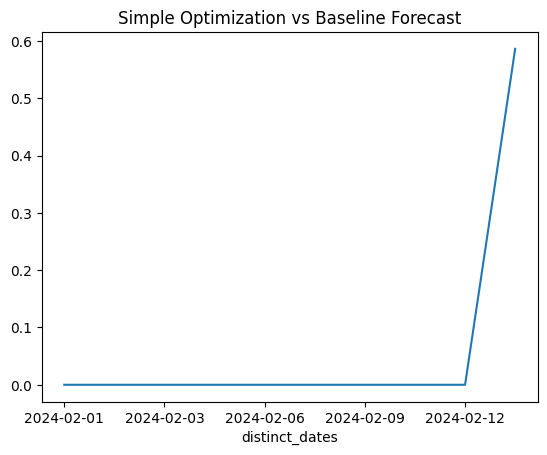

In [30]:
(synth_data["greedy_fit_results"] - synth_data["simple_fit_results"]).plot(kind='line', title = "Simple Optimization vs Baseline Forecast")

In [41]:
synth_data[["greedy_fit_results","simple_fit_results"]]

,greedy_fit_results,simple_fit_results
distinct_dates,,
2024-02-01,47.187491,47.187491
2024-02-02,22.589339,22.589339
2024-02-03,36.602137,36.602137
2024-02-04,38.696790,38.696790
2024-02-06,38.783459,38.783459
2024-02-07,32.945116,32.945116
2024-02-09,44.226820,44.226820
2024-02-11,32.683452,32.683452
2024-02-12,45.048832,45.048832


<Axes: title={'center': 'Simple Optimization vs Baseline Forecast'}, xlabel='distinct_dates'>

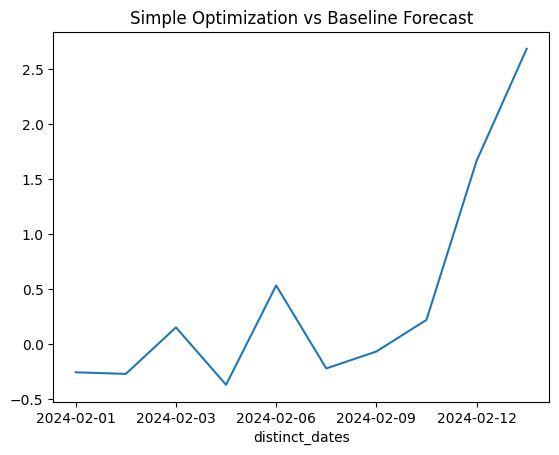

In [33]:
(synth_data["simple_fit_results_actual"] - synth_data["simple_fit_results"]).plot(kind='line', title = "Simple Optimization vs Baseline Forecast")